In [7]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

import sys
import torchvision
import matplotlib

print("python version :", sys.version)
print("pandas version :", pd.__version__)
print("torch version :", torch.__version__)
print("torchvision version :", torchvision.__version__)
print("matplotlib version :", matplotlib.__version__)

python version : 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
pandas version : 1.5.3
torch version : 2.2.1
torchvision version : 0.17.1
matplotlib version : 3.4.3


In [6]:
# GPU 사용 가능 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU")

GPU is available. Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


---

# 채널 평균, 표준편차 정규화 / ResNet34 / lr=0.01 / SGD+momentum

In [32]:
# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

In [33]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

In [34]:
# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

In [37]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [38]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [35]:
# 모델 정의
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        self.resnet = models.resnet34(pretrained=False)
        # 첫 번째 컨볼루션 레이어를 1채널 입력에 맞게 수정
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, x):
        return self.resnet(x)

In [36]:
model = myResNet().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [39]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.4726, Accuracy: 46.98%
Test loss: 1.2422, Accuracy: 56.55%
Epoch: 2, Training Loss: 1.1405, Accuracy: 60.37%
Test loss: 1.0847, Accuracy: 62.20%
Epoch: 3, Training Loss: 0.9460, Accuracy: 67.45%
Test loss: 1.0868, Accuracy: 61.75%
Epoch: 4, Training Loss: 0.7936, Accuracy: 72.59%
Test loss: 0.9772, Accuracy: 67.67%
Epoch: 5, Training Loss: 0.6655, Accuracy: 77.23%
Test loss: 1.0194, Accuracy: 65.77%
Epoch: 6, Training Loss: 0.5594, Accuracy: 80.97%
Test loss: 0.9875, Accuracy: 68.65%
Epoch: 7, Training Loss: 0.4549, Accuracy: 84.38%
Test loss: 1.0674, Accuracy: 68.04%
Epoch: 8, Training Loss: 0.3575, Accuracy: 87.93%
Test loss: 1.1263, Accuracy: 67.23%
Epoch: 9, Training Loss: 0.2984, Accuracy: 89.64%
Test loss: 1.2299, Accuracy: 68.34%
Epoch: 10, Training Loss: 0.2447, Accuracy: 91.54%
Test loss: 1.2564, Accuracy: 69.52%


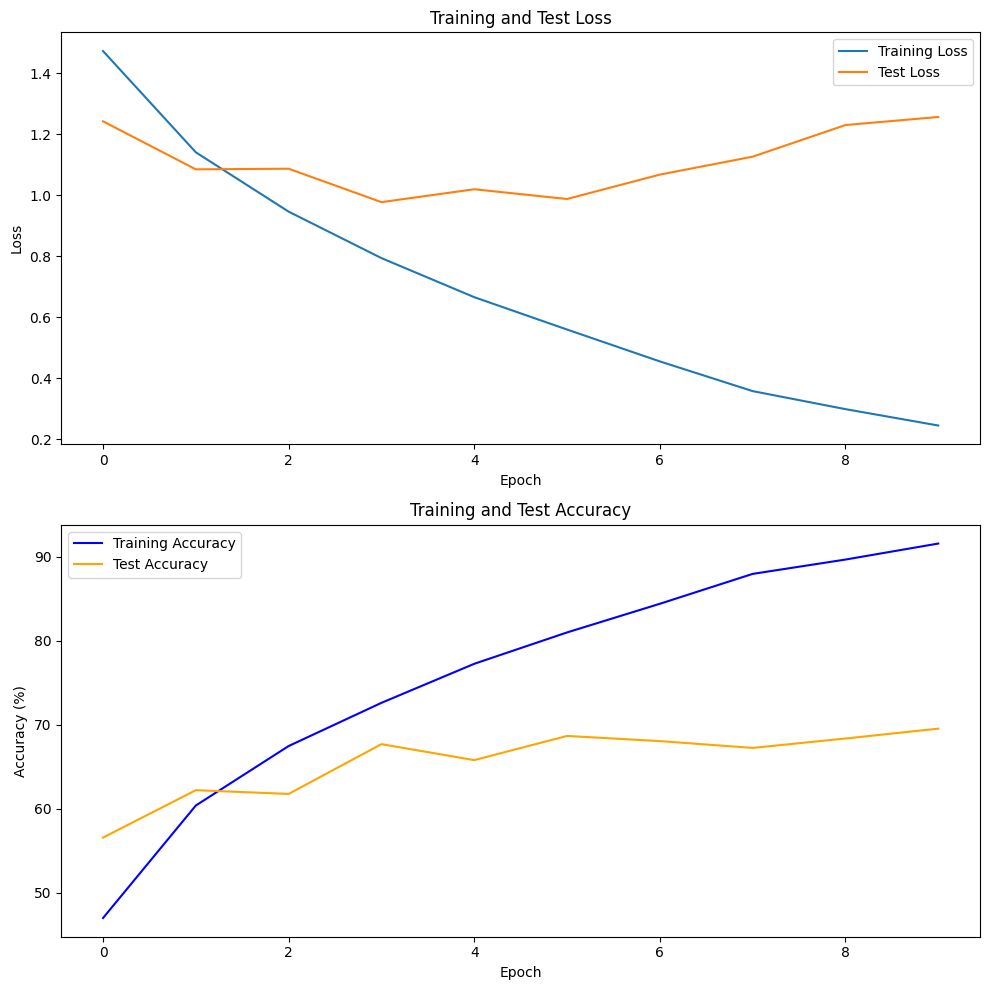

In [40]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


---

# 채널 평균, 표준편차 정규화 / ResNet18 / lr=0.01 / SGD+momentum

In [53]:
# 모델 정의
class myResNet18(nn.Module):
    def __init__(self):
        super(myResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # 첫 번째 컨볼루션 레이어를 1채널 입력에 맞게 수정
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, x):
        return self.resnet(x)

In [54]:
model = myResNet18().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [55]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.3650, Accuracy: 51.15%
Test loss: 1.1880, Accuracy: 59.32%
Epoch: 2, Training Loss: 1.0516, Accuracy: 62.98%
Test loss: 1.0748, Accuracy: 61.55%
Epoch: 3, Training Loss: 0.8717, Accuracy: 69.43%
Test loss: 1.0351, Accuracy: 64.60%
Epoch: 4, Training Loss: 0.7202, Accuracy: 74.97%
Test loss: 0.9751, Accuracy: 67.39%
Epoch: 5, Training Loss: 0.5735, Accuracy: 80.26%
Test loss: 1.1078, Accuracy: 66.64%
Epoch: 6, Training Loss: 0.4533, Accuracy: 84.24%
Test loss: 1.0517, Accuracy: 68.59%
Epoch: 7, Training Loss: 0.3568, Accuracy: 87.65%
Test loss: 1.1941, Accuracy: 65.88%
Epoch: 8, Training Loss: 0.2672, Accuracy: 90.71%
Test loss: 1.3354, Accuracy: 65.16%
Epoch: 9, Training Loss: 0.2139, Accuracy: 92.49%
Test loss: 1.3581, Accuracy: 68.87%
Epoch: 10, Training Loss: 0.1650, Accuracy: 94.51%
Test loss: 1.3536, Accuracy: 67.34%


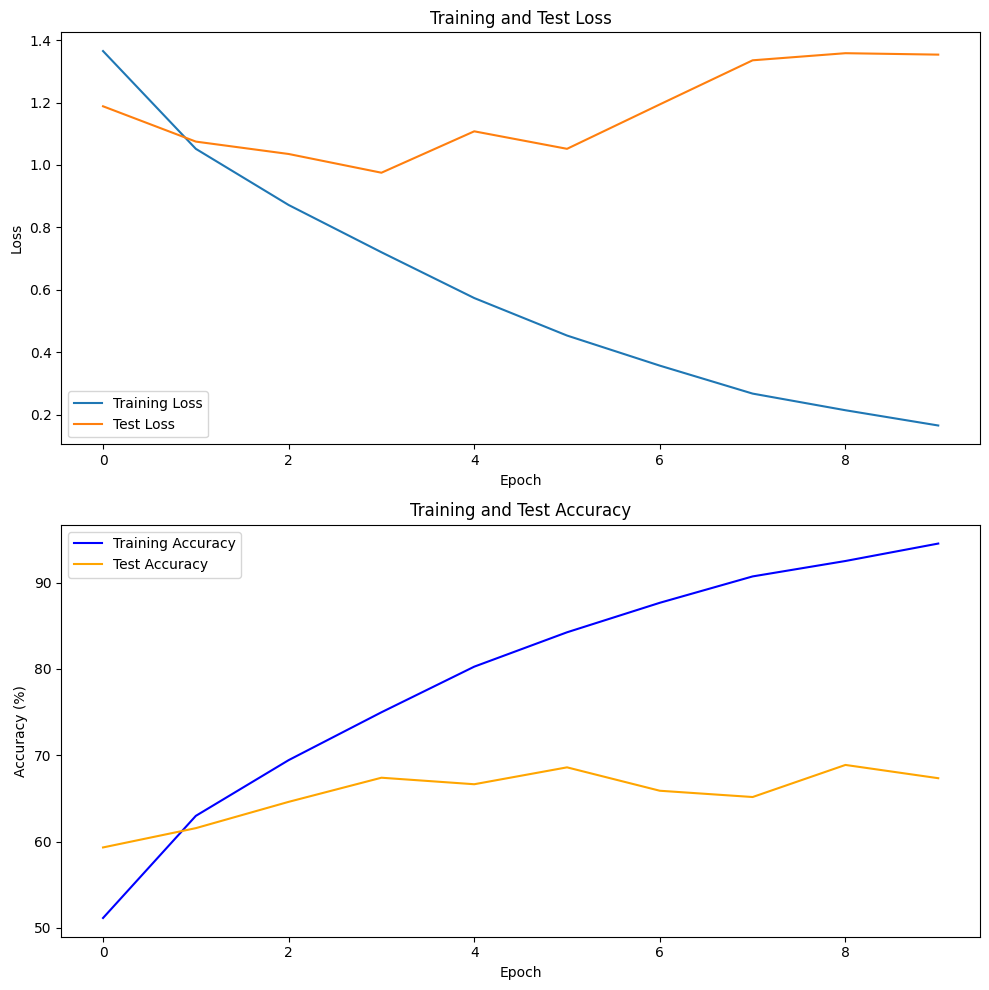

In [56]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


----

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.01 / SGD+momentum

In [46]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [47]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [48]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.5688, Accuracy: 41.27%
Test loss: 1.3410, Accuracy: 55.91%
Epoch: 2, Training Loss: 1.2338, Accuracy: 58.74%
Test loss: 1.1284, Accuracy: 62.39%
Epoch: 3, Training Loss: 1.0350, Accuracy: 65.14%
Test loss: 0.9784, Accuracy: 67.09%
Epoch: 4, Training Loss: 0.9044, Accuracy: 69.61%
Test loss: 0.8828, Accuracy: 70.75%
Epoch: 5, Training Loss: 0.7999, Accuracy: 72.90%
Test loss: 0.8435, Accuracy: 72.37%
Epoch: 6, Training Loss: 0.7138, Accuracy: 75.82%
Test loss: 0.7920, Accuracy: 74.02%
Epoch: 7, Training Loss: 0.6356, Accuracy: 78.37%
Test loss: 0.7903, Accuracy: 74.71%
Epoch: 8, Training Loss: 0.5552, Accuracy: 81.26%
Test loss: 0.8002, Accuracy: 74.04%
Epoch: 9, Training Loss: 0.4893, Accuracy: 83.70%
Test loss: 0.8874, Accuracy: 71.98%
Epoch: 10, Training Loss: 0.4220, Accuracy: 86.16%
Test loss: 0.8468, Accuracy: 74.99%


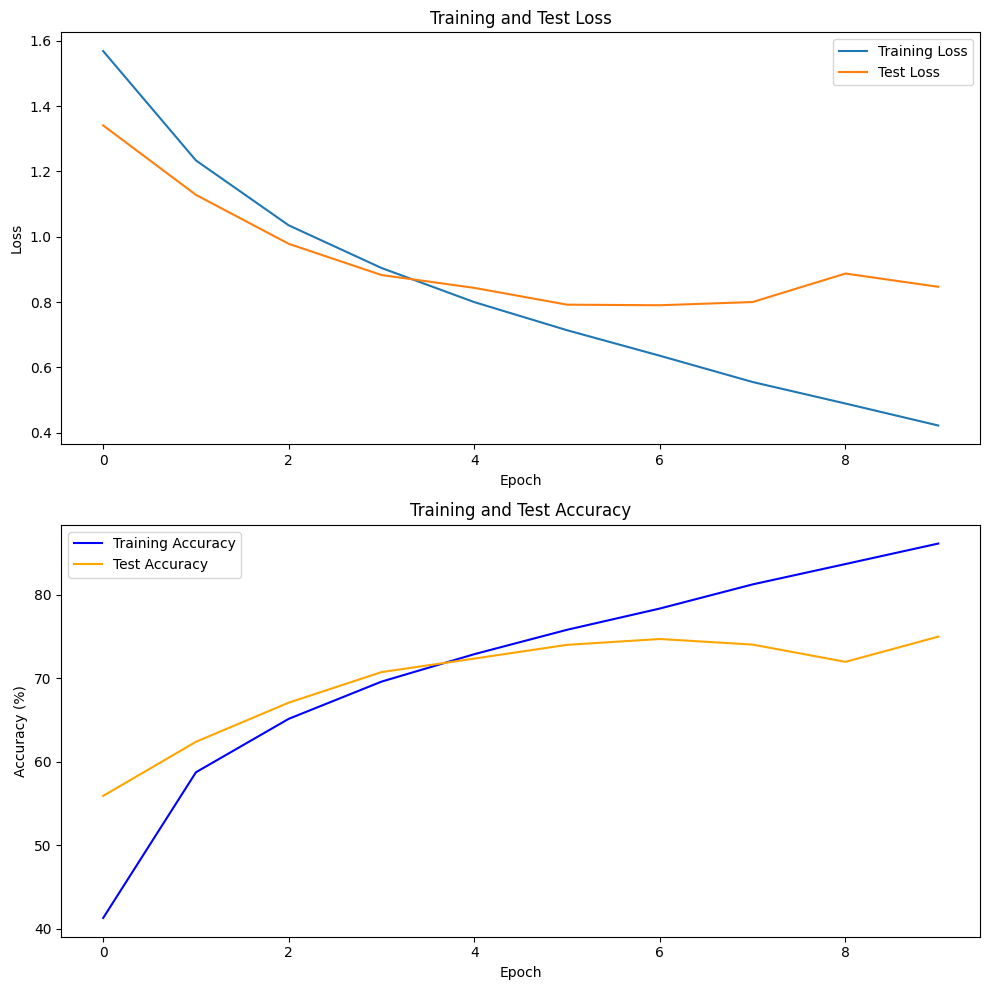

In [49]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


---

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.01 / Adam

In [60]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [61]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [62]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1380608113.1379, Accuracy: 33.36%
Test loss: 1.6403, Accuracy: 37.30%
Epoch: 2, Training Loss: 1.7366, Accuracy: 36.07%
Test loss: 1.6392, Accuracy: 37.30%
Epoch: 3, Training Loss: 1.6492, Accuracy: 36.07%
Test loss: 1.6396, Accuracy: 37.30%
Epoch: 4, Training Loss: 1.6400, Accuracy: 36.10%
Test loss: 1.6395, Accuracy: 37.30%
Epoch: 5, Training Loss: 1.6326, Accuracy: 36.09%
Test loss: 1.6388, Accuracy: 37.30%
Epoch: 6, Training Loss: 1.6966, Accuracy: 36.11%
Test loss: 1.6391, Accuracy: 37.30%
Epoch: 7, Training Loss: 1.7447, Accuracy: 36.08%
Test loss: 1.6390, Accuracy: 37.30%
Epoch: 8, Training Loss: 1.7295, Accuracy: 36.08%
Test loss: 1.6399, Accuracy: 37.30%
Epoch: 9, Training Loss: 1.6303, Accuracy: 36.09%
Test loss: 1.6429, Accuracy: 37.30%
Epoch: 10, Training Loss: 1.6302, Accuracy: 36.09%
Test loss: 1.6387, Accuracy: 37.30%


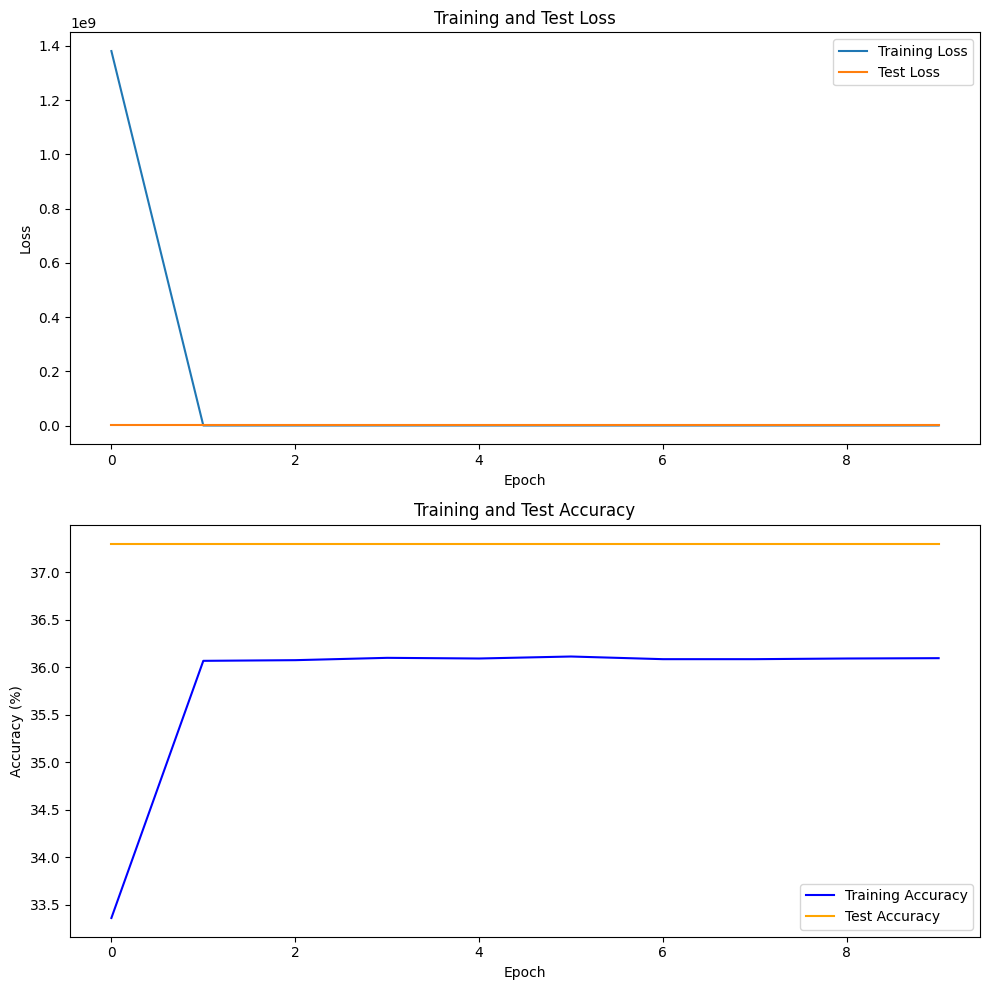

In [63]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()


---

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.1 / SGD+momentum

In [64]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [65]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

In [66]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.6679, Accuracy: 35.29%
Test loss: 1.6419, Accuracy: 37.30%
Epoch: 2, Training Loss: 1.6359, Accuracy: 35.72%
Test loss: 1.6628, Accuracy: 25.12%
Epoch: 3, Training Loss: 1.6355, Accuracy: 35.78%
Test loss: 1.6393, Accuracy: 37.30%
Epoch: 4, Training Loss: 1.6341, Accuracy: 35.95%
Test loss: 1.6395, Accuracy: 37.30%
Epoch: 5, Training Loss: 1.6335, Accuracy: 36.00%
Test loss: 1.6438, Accuracy: 37.30%
Epoch: 6, Training Loss: 1.6335, Accuracy: 35.99%
Test loss: 1.6391, Accuracy: 37.30%
Epoch: 7, Training Loss: 1.6330, Accuracy: 36.06%
Test loss: 1.6387, Accuracy: 37.30%
Epoch: 8, Training Loss: 1.6327, Accuracy: 35.98%
Test loss: 1.6402, Accuracy: 37.30%
Epoch: 9, Training Loss: 1.6324, Accuracy: 36.04%
Test loss: 1.6393, Accuracy: 37.30%
Epoch: 10, Training Loss: 1.6320, Accuracy: 36.06%
Test loss: 1.6430, Accuracy: 37.30%


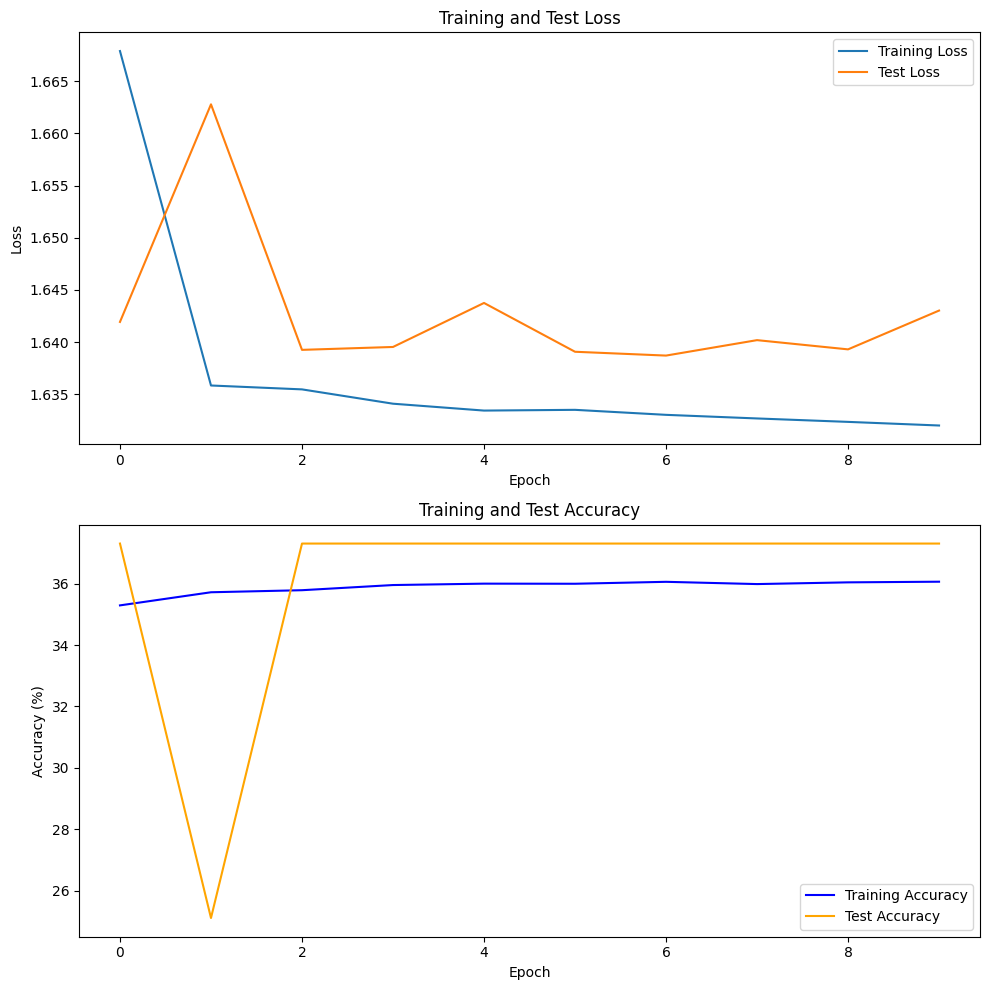

In [67]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.001 / SGD+momentum

In [68]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [69]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

In [70]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.6586, Accuracy: 35.71%
Test loss: 1.6050, Accuracy: 39.96%
Epoch: 2, Training Loss: 1.5628, Accuracy: 41.28%
Test loss: 1.4851, Accuracy: 46.19%
Epoch: 3, Training Loss: 1.4344, Accuracy: 49.59%
Test loss: 1.3858, Accuracy: 51.19%
Epoch: 4, Training Loss: 1.3191, Accuracy: 54.89%
Test loss: 1.2918, Accuracy: 57.39%
Epoch: 5, Training Loss: 1.2377, Accuracy: 58.03%
Test loss: 1.2430, Accuracy: 57.19%
Epoch: 6, Training Loss: 1.1702, Accuracy: 60.29%
Test loss: 1.1701, Accuracy: 60.46%
Epoch: 7, Training Loss: 1.1041, Accuracy: 62.61%
Test loss: 1.1022, Accuracy: 62.45%
Epoch: 8, Training Loss: 1.0415, Accuracy: 64.85%
Test loss: 1.1098, Accuracy: 62.62%
Epoch: 9, Training Loss: 0.9738, Accuracy: 66.95%
Test loss: 1.0448, Accuracy: 64.40%
Epoch: 10, Training Loss: 0.9090, Accuracy: 69.14%
Test loss: 1.0565, Accuracy: 65.58%


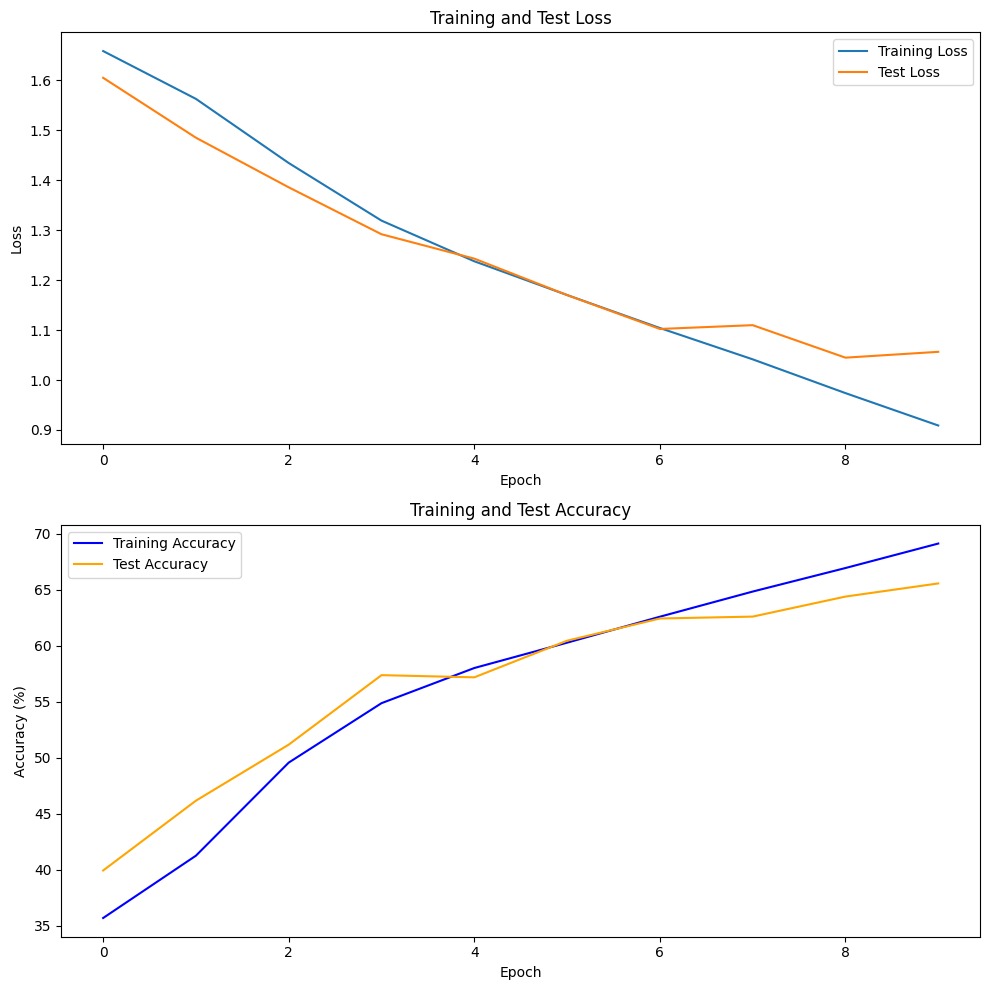

In [71]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

---

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.01 / SGD+momentum (다시 돌리니까 조금 더 좋게 나옴)

In [72]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [73]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

In [74]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.5954, Accuracy: 38.47%
Test loss: 1.3815, Accuracy: 51.89%
Epoch: 2, Training Loss: 1.2815, Accuracy: 56.65%
Test loss: 1.1584, Accuracy: 60.74%
Epoch: 3, Training Loss: 1.0647, Accuracy: 64.09%
Test loss: 0.9910, Accuracy: 67.34%
Epoch: 4, Training Loss: 0.9206, Accuracy: 68.95%
Test loss: 1.0012, Accuracy: 66.42%
Epoch: 5, Training Loss: 0.8167, Accuracy: 72.51%
Test loss: 0.8802, Accuracy: 71.50%
Epoch: 6, Training Loss: 0.7262, Accuracy: 75.26%
Test loss: 0.8108, Accuracy: 73.20%
Epoch: 7, Training Loss: 0.6492, Accuracy: 78.15%
Test loss: 0.7969, Accuracy: 73.01%
Epoch: 8, Training Loss: 0.5721, Accuracy: 80.46%
Test loss: 0.7397, Accuracy: 75.52%
Epoch: 9, Training Loss: 0.5002, Accuracy: 83.08%
Test loss: 0.7676, Accuracy: 74.85%
Epoch: 10, Training Loss: 0.4387, Accuracy: 85.36%
Test loss: 0.9451, Accuracy: 71.89%


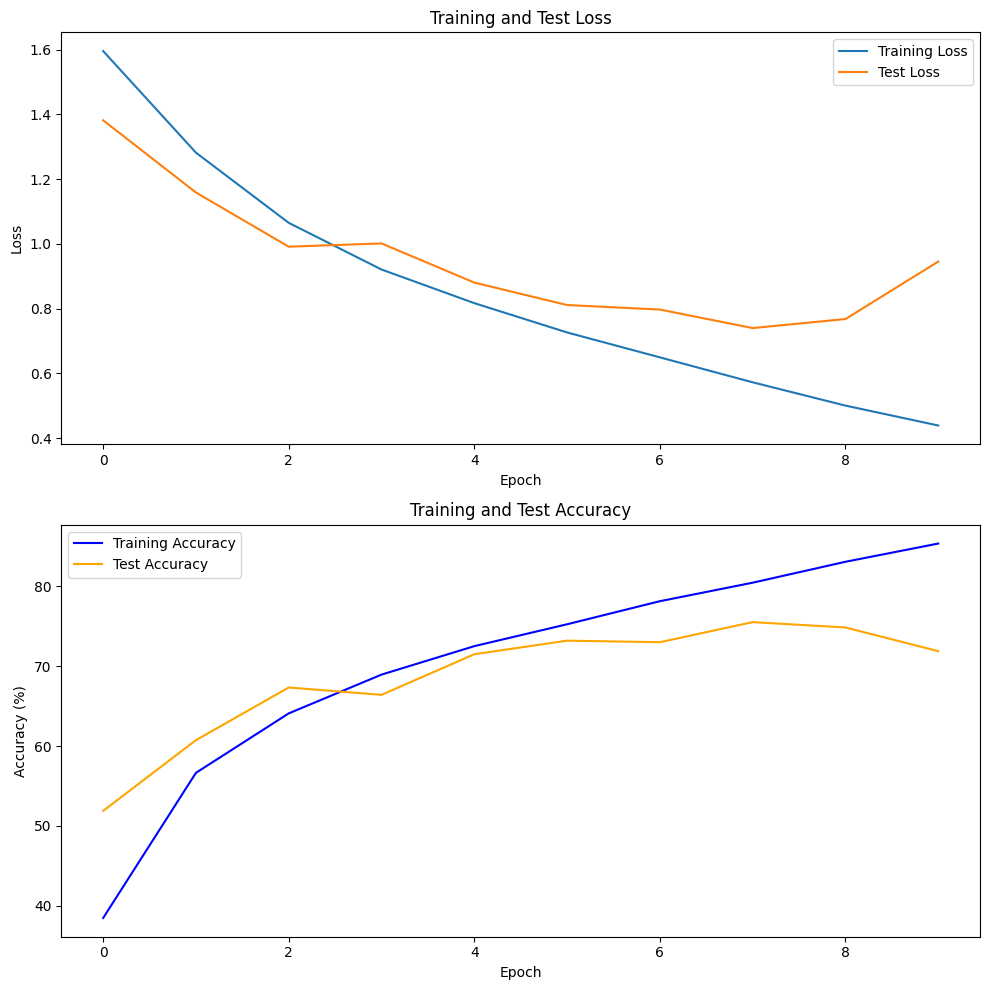

In [75]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

---

# 채널 평균, 표준편차 정규화 / VGG16 / lr=0.01 / SGD+momentum (데이터 증강 버전)

In [76]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [77]:
# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

In [78]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

In [79]:
# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data1/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data1/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

In [91]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [92]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [82]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [83]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [84]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.5855, Accuracy: 39.03%
Test loss: 1.4739, Accuracy: 48.31%
Epoch: 2, Training Loss: 1.2629, Accuracy: 57.40%
Test loss: 1.2457, Accuracy: 57.17%
Epoch: 3, Training Loss: 1.0548, Accuracy: 64.75%
Test loss: 0.9586, Accuracy: 67.64%
Epoch: 4, Training Loss: 0.9166, Accuracy: 68.77%
Test loss: 0.9145, Accuracy: 68.15%
Epoch: 5, Training Loss: 0.8177, Accuracy: 72.20%
Test loss: 0.8683, Accuracy: 70.77%
Epoch: 6, Training Loss: 0.7293, Accuracy: 75.22%
Test loss: 0.8359, Accuracy: 72.67%
Epoch: 7, Training Loss: 0.6545, Accuracy: 77.98%
Test loss: 0.8398, Accuracy: 70.22%
Epoch: 8, Training Loss: 0.5746, Accuracy: 80.82%
Test loss: 0.7767, Accuracy: 73.88%
Epoch: 9, Training Loss: 0.5070, Accuracy: 83.09%
Test loss: 0.8113, Accuracy: 73.37%
Epoch: 10, Training Loss: 0.4394, Accuracy: 85.45%
Test loss: 0.8808, Accuracy: 72.62%


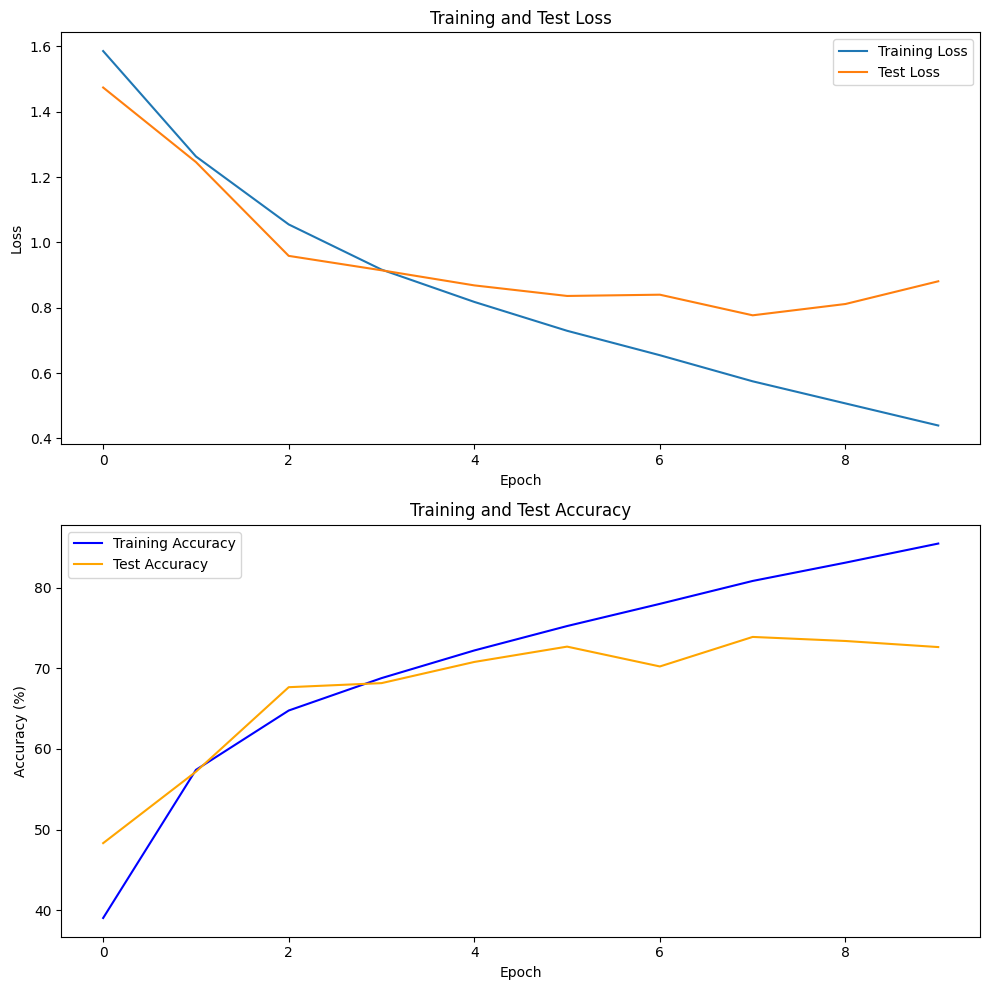

In [85]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [86]:
# 학습 시킨 모델 저장
torch.save(model, './vgg16_model.pt')

# valid+test 합쳐서 vgg16

In [89]:
# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        
        if 'Train' in directory:
            self.df = self.df[self.df['Usage'] =='Training']
        elif 'Valid' in directory:
            self.df = self.df[self.df['Usage'] == 'PublicTest']
        else: 
            self.df = self.df[self.df['Usage'] == 'PrivateTest']
        

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

In [90]:
from torch.utils.data import ConcatDataset

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성
# test+valid
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test1_dataset = CustomImageDataset(directory='./data/FER2013Valid', csv_file='./fer2013new.csv', transform=transform)
test2_dataset = CustomImageDataset(directory='./data/FER2013Test', csv_file='./fer2013new.csv', transform=transform)

test_dataset = ConcatDataset([test1_dataset, test2_dataset])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)



In [93]:
# 모델 정의
class myVGG16(nn.Module):
    def __init__(self):
        super(myVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=False)
        self.vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg16(x)

In [94]:
model = myVGG16().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []  # 초기화
train_accuracies = []  # 초기화
test_losses = []  # 초기화
test_accuracies = []  # 초기화

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [95]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch: 1, Training Loss: 1.5862, Accuracy: 39.04%
Test loss: 1.5009, Accuracy: 44.28%
Epoch: 2, Training Loss: 1.2785, Accuracy: 56.65%
Test loss: 1.1591, Accuracy: 60.72%
Epoch: 3, Training Loss: 1.0696, Accuracy: 63.87%
Test loss: 0.9967, Accuracy: 66.00%
Epoch: 4, Training Loss: 0.9256, Accuracy: 68.47%
Test loss: 0.9711, Accuracy: 67.36%
Epoch: 5, Training Loss: 0.8205, Accuracy: 72.18%
Test loss: 0.8988, Accuracy: 70.52%
Epoch: 6, Training Loss: 0.7399, Accuracy: 75.07%
Test loss: 0.8527, Accuracy: 71.66%
Epoch: 7, Training Loss: 0.6547, Accuracy: 77.74%
Test loss: 0.8298, Accuracy: 73.49%
Epoch: 8, Training Loss: 0.5837, Accuracy: 80.23%
Test loss: 0.8233, Accuracy: 73.63%
Epoch: 9, Training Loss: 0.5111, Accuracy: 82.91%
Test loss: 0.8657, Accuracy: 72.68%
Epoch: 10, Training Loss: 0.4408, Accuracy: 85.21%
Test loss: 0.8501, Accuracy: 74.63%


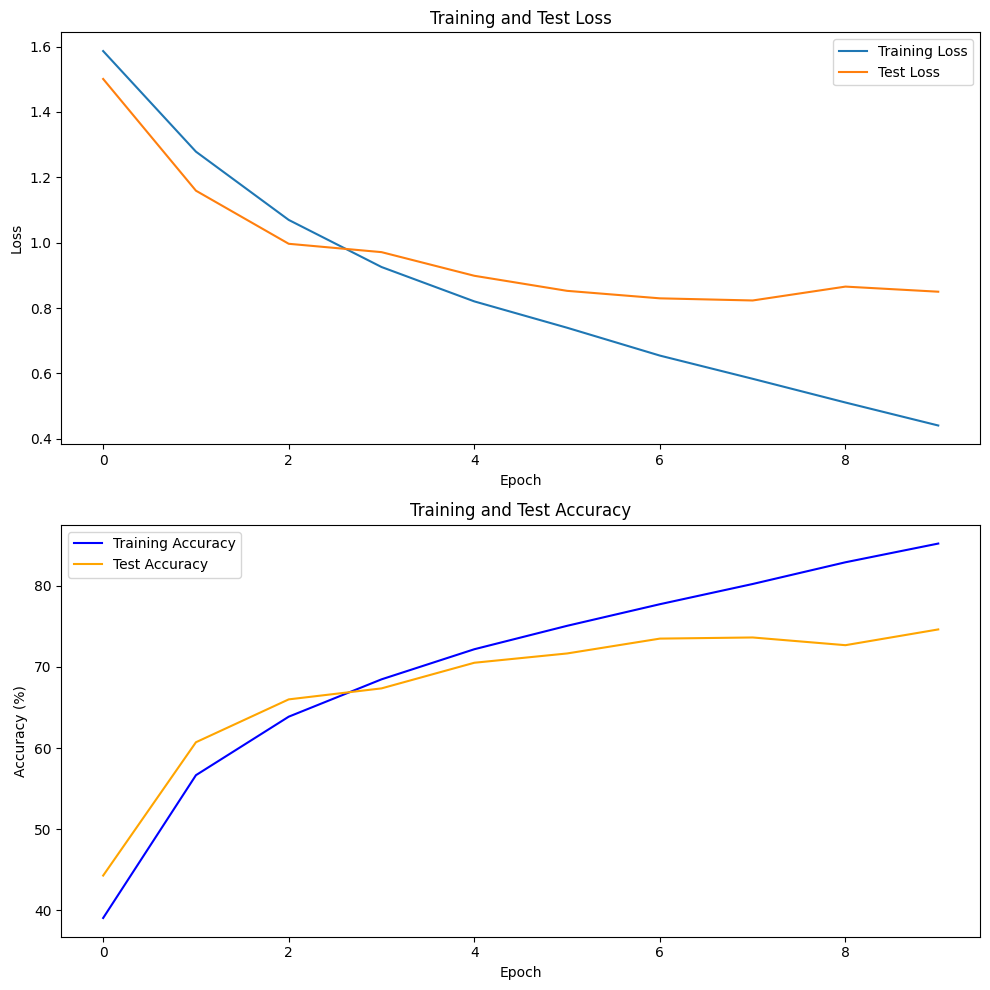

In [96]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

# 최종 모델

In [118]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.checkpoint_path = checkpoint_path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.checkpoint_path)


In [119]:
# Custom Dataset 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, directory, csv_file, transform=None):
        self.directory = directory
        self.transform = transform
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['Image name'])
        self.df = self.df[self.df['Usage'] == ('Training' if 'Train' in directory else 'PublicTest')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.df.iloc[idx]['Image name'])
        image = Image.open(img_name)
        label = self.df.iloc[idx][2:12].values.argmax()
        if self.transform:
            image = self.transform(image)
        return image, label

In [120]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5076,], std=[0.2120]),  # 1채널 이미지에 맞게 조정
])

# 데이터셋과 데이터로더 생성 (배치 크기 감소)
train_dataset = CustomImageDataset(directory='./data/FER2013Train', csv_file='./fer2013new.csv', transform=transform)
test_dataset = CustomImageDataset(directory='./data/FER2013valid', csv_file='./fer2013new.csv', transform=transform)

# 메모리 때문에 배치 줄임
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 배치 크기 감소
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 배치 크기 감소

In [121]:
# 모델 정의
class myVGG19(nn.Module):
    def __init__(self):
        super(myVGG19, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # 첫 번째 레이어를 1채널 입력에 맞게 수정
        num_ftrs = self.vgg19.classifier[6].in_features
        self.vgg19.classifier[6] = nn.Linear(num_ftrs, 10)  # 마지막 레이어를 10개 클래스에 맞게 조정
    
    def forward(self, x):
        return self.vgg19(x)


In [123]:
model = myVGG19().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ysh93\anaconda3\envs\SOHYUN\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [124]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

early_stopper = EarlyStopping(patience=5, min_delta=0.01, checkpoint_path='./model_checkpoint.pt')

In [126]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)  # 배치 크기를 고려
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss /= total
    accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [127]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    test_loss /= total
    accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f"Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [128]:
for epoch in range(1, 100):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    
    early_stopper(test_losses[-1], model)
    if early_stopper.early_stop:
        print("Early stopping")
        break

Epoch: 1, Training Loss: 1.5997, Accuracy: 37.95%
Test loss: 1.4142, Accuracy: 51.22%
Epoch: 2, Training Loss: 1.2970, Accuracy: 56.37%
Test loss: 1.2040, Accuracy: 59.71%
Epoch: 3, Training Loss: 1.0944, Accuracy: 63.10%
Test loss: 1.0233, Accuracy: 65.47%
Epoch: 4, Training Loss: 0.9533, Accuracy: 67.59%
Test loss: 0.9097, Accuracy: 69.04%
Epoch: 5, Training Loss: 0.8582, Accuracy: 71.01%
Test loss: 0.8802, Accuracy: 71.30%
Epoch: 6, Training Loss: 0.7802, Accuracy: 73.29%
Test loss: 0.8465, Accuracy: 72.14%
Epoch: 7, Training Loss: 0.7046, Accuracy: 76.31%
Test loss: 0.8922, Accuracy: 69.52%
EarlyStopping counter: 1 out of 5
Epoch: 8, Training Loss: 0.6328, Accuracy: 78.70%
Test loss: 0.7649, Accuracy: 74.55%
Epoch: 9, Training Loss: 0.5724, Accuracy: 80.63%
Test loss: 0.8906, Accuracy: 71.84%
EarlyStopping counter: 1 out of 5
Epoch: 10, Training Loss: 0.5065, Accuracy: 83.00%
Test loss: 0.8674, Accuracy: 75.38%
EarlyStopping counter: 2 out of 5
Epoch: 11, Training Loss: 0.4493, Acc

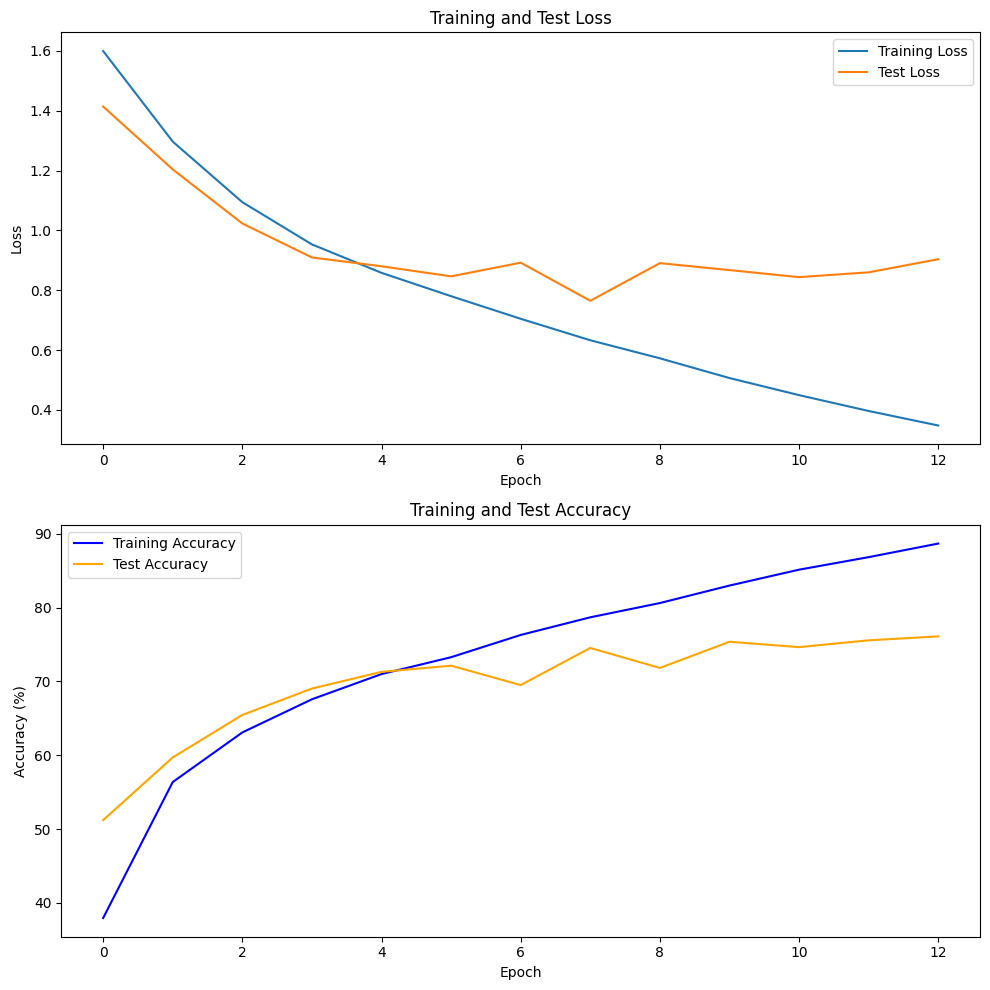

In [130]:
# 손실 및 정확도 시각화
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [129]:
# 학습 시킨 모델 저장
torch.save(model, './vgg19basic_model.pt')